In [1]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
database1train = "CK_dataset/train"
database1test = "CK_dataset/test"
database2train = "JAFFE-[70,30]/train"
database2test = "JAFFE-[70,30]/test"

In [3]:
def load_and_detect_faces(folder_path):
    images = []
    labels = []
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
                    for (x, y, w, h) in faces:
                        face_region = img[y:y+h, x:x+w]
                        images.append(face_region)
                        labels.append(label)
    return images, labels

In [4]:
train_folder_path = database2train
test_folder_path = database2test
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [5]:
radius = 1
n_points = 8 * radius
def extract_lbp_features(images):
    lbp_features = []
    for img in images:
        img = cv2.resize(img, (64, 64))  # Standardize size
        lbp = local_binary_pattern(img, n_points, radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.append(hist)
    return np.array(lbp_features)

In [6]:
X_train_faces, y_train = load_and_detect_faces(train_folder_path)
X_train_features = extract_lbp_features(X_train_faces)
X_test_faces, y_test = load_and_detect_faces(test_folder_path)
X_test_features = extract_lbp_features(X_test_faces)

In [8]:
param_grid = {
    'svc__C': [4, 4.5, 5, 6, 7, 8, 9, 10],  
    'svc__gamma': ['scale'], 
    'svc__kernel': ['rbf']
}
svm_pipeline = make_pipeline(StandardScaler(), SVC())
grid_search = GridSearchCV(svm_pipeline, param_grid, refit=True, verbose=3, cv=10)
grid_search.fit(X_train_features, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)



Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.231 total time=   0.0s
[CV 2/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.385 total time=   0.0s
[CV 3/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.308 total time=   0.0s
[CV 4/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.385 total time=   0.0s
[CV 5/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.308 total time=   0.0s
[CV 6/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.154 total time=   0.0s
[CV 7/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.308 total time=   0.0s
[CV 8/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.231 total time=   0.0s
[CV 9/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.417 total time=   0.0s
[CV 10/10] END svc__C=4, svc__gamma=scale, svc__kernel=rbf;, score=0.250 total time=   0.0s
[CV 1/10] END svc__C=4.5, sv

In [9]:
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=4.5, gamma='scale'))
svm_classifier.fit(X_train_features, y_train)
y_pred = svm_classifier.predict(X_test_features)
svm_classifier.fit(X_train_features, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=4.5))])

In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = svm_classifier.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(len(y_test))
print(conf_matrix)

Accuracy: 25.45%
              precision    recall  f1-score   support

       Angry       0.30      0.33      0.32         9
        Fear       0.20      0.10      0.13        10
       Happy       0.31      0.56      0.40         9
     Neutral       1.00      0.11      0.20         9
         Sad       0.33      0.11      0.17         9
    Surprise       0.15      0.33      0.21         9

    accuracy                           0.25        55
   macro avg       0.38      0.26      0.24        55
weighted avg       0.38      0.25      0.24        55

55
[[3 1 0 0 0 5]
 [0 1 4 0 0 5]
 [1 0 5 0 2 1]
 [1 0 3 1 0 4]
 [3 1 2 0 1 2]
 [2 2 2 0 0 3]]


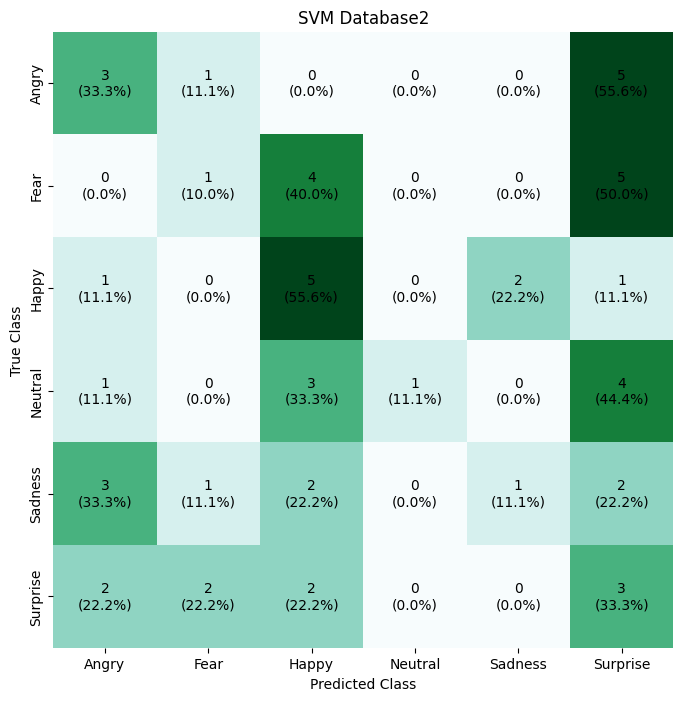

In [11]:
class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100
plt.figure(figsize=(8, 8))
ax = sns.heatmap(conf_matrix, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        count = conf_matrix[i, j]
        percent = conf_matrix_percent[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}\n({percent:.1f}%)", ha="center", va="center", color="black", fontsize=10)

plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("SVM Database2")
plt.show()


In [15]:
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1, 25)
best_knn_accuracy = 0
best_k = 1

for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_features, y_train)
    y_pred = knn_model.predict(X_test_features)
    knn_accuracy = accuracy_score(y_test, y_pred)
    if knn_accuracy > best_knn_accuracy:
        best_knn_accuracy = knn_accuracy
        best_k = k
final_knn_model = KNeighborsClassifier(n_neighbors=best_k)
final_knn_model.fit(X_train_features, y_train)
y_pred = final_knn_model.predict(X_test_features)


In [17]:
knn_accuracy = accuracy_score(y_test, y_pred)
print("Best k:", best_k)
print("Accuracy:", knn_accuracy)
print(classification_report(y_test, y_pred))

Best k: 4
Accuracy: 0.2727272727272727
              precision    recall  f1-score   support

       Angry       0.33      0.33      0.33         9
        Fear       0.22      0.20      0.21        10
       Happy       0.33      0.44      0.38         9
     Neutral       0.00      0.00      0.00         9
         Sad       0.50      0.11      0.18         9
    Surprise       0.22      0.56      0.31         9

    accuracy                           0.27        55
   macro avg       0.27      0.27      0.24        55
weighted avg       0.27      0.27      0.24        55



C:\Users\digim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\digim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\digim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

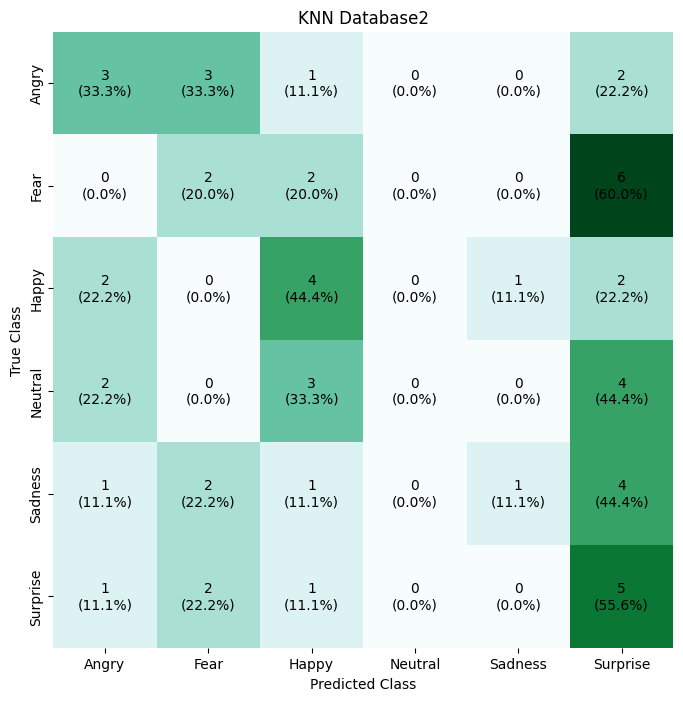

In [18]:
knn_predictions = final_knn_model.predict(X_test_features)
conf_matrix_knn = confusion_matrix(y_test, knn_predictions)
class_names = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]
conf_matrix_percent_knn = conf_matrix_knn / conf_matrix_knn.sum(axis=1, keepdims=True) * 100
plt.figure(figsize=(8, 8))
ax = sns.heatmap(conf_matrix_knn, annot=False, cmap="BuGn", xticklabels=class_names, yticklabels=class_names, cbar=False)
for i in range(conf_matrix_knn.shape[0]):
    for j in range(conf_matrix_knn.shape[1]):
        count = conf_matrix_knn[i, j]
        percent = conf_matrix_percent_knn[i, j]
        ax.text(j + 0.5, i + 0.5, f"{count}\n({percent:.1f}%)", ha="center", va="center", color="black", fontsize=10)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("KNN Database2")
plt.show()
